In [1]:
#!pip install pandas_datareader -q
#!pip install PyPortfolioOpt -q

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pypfopt
%load_ext autoreload
%autoreload 2


# Stock Selection

BRKA portfolio tracker: https://www.dataroma.com/m/holdings.php?m=BRK 

Here, we referred to the link above to identify what are the major components of the Berkshire Portfolio.

We try to select a manageable number of stocks, in this case 10, which are generally uncorrelated with each other to allow us to build a more stable portfolio.

In [2]:
start = datetime(2010, 1, 1)
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']

symbols = []
for ticker in symbols_list:
    r = web.DataReader(ticker, 'yahoo', start)
    r["Symbol"] = ticker
    symbols.append(r)
    
eq_df = pd.concat(symbols).reset_index()
eq_df = eq_df[['Date', 'Close', 'Symbol']]
eq_df.head()

,Date,Close,Symbol
0,2009-12-31,7.526072,AAPL
1,2010-01-04,7.643214,AAPL
2,2010-01-05,7.656428,AAPL
3,2010-01-06,7.534643,AAPL
4,2010-01-07,7.520714,AAPL


In [3]:
eq_pivot = eq_df.pivot('Date', 'Symbol', 'Close')
eq_pivot.head()

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
2009-12-31,7.526072,134.520004,103.169998,40.520000,28.500000,7.870000,35.310001,NaN,3.40875,22.292490
2010-01-04,7.643214,133.899994,105.870003,40.919998,28.520000,7.640000,36.759998,NaN,3.51000,22.740448
2010-01-05,7.656428,134.690002,107.120003,40.830002,28.174999,7.358572,37.270000,NaN,3.61500,22.766798
2010-01-06,7.534643,132.250000,108.800003,41.490002,28.165001,7.617143,38.009998,NaN,3.69500,22.555994
2010-01-07,7.520714,130.000000,107.150002,41.980000,28.094999,7.485714,37.509998,NaN,3.65125,22.661396


In [4]:
corr_matrix = eq_pivot.corr(method='pearson')
corr_matrix.head().reset_index()
del corr_matrix.index.name
corr_matrix

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
AAPL,1.000000,0.951354,-0.821147,0.743723,0.762624,0.916867,-0.464296,0.878296,0.046930,0.037935
AMZN,0.951354,1.000000,-0.843114,0.756221,0.751174,0.984420,-0.393844,0.786440,-0.008856,0.019669
APA,-0.821147,-0.843114,1.000000,-0.746407,-0.829864,-0.837706,0.565089,-0.617835,-0.324857,-0.093193
AXP,0.743723,0.756221,-0.746407,1.000000,0.882722,0.780878,-0.062066,0.483643,0.285845,0.481752
KO,0.762624,0.751174,-0.829864,0.882722,1.000000,0.741226,-0.263049,0.522475,0.395989,0.337382
NFLX,0.916867,0.984420,-0.837706,0.780878,0.741226,1.000000,-0.313092,0.725896,0.018028,0.092269
SU,-0.464296,-0.393844,0.565089,-0.062066,-0.263049,-0.313092,1.000000,-0.556382,-0.128841,0.420772
TSLA,0.878296,0.786440,-0.617835,0.483643,0.522475,0.725896,-0.556382,1.000000,-0.018147,-0.112446
UAA,0.046930,-0.008856,-0.324857,0.285845,0.395989,0.018028,-0.128841,-0.018147,1.000000,0.400116
XRX,0.037935,0.019669,-0.093193,0.481752,0.337382,0.092269,0.420772,-0.112446,0.400116,1.000000


# Correlation heatmap

We can verify that we got a good mix of stocks which do not have a general tendencey to follow the same direction with each other

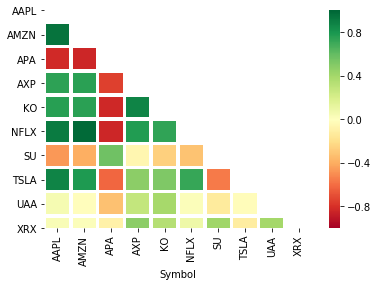

In [5]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
#generate plot
sns.heatmap(corr_matrix, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Wealth Plot

The wealth plot tells us how how much we would have at a point t in time, if we were to buy and hold

In [6]:
spy_data = web.DataReader('SPY', 'yahoo', '2010-01-02') # 1) Load web data
brka_data = pd.read_csv("data/BRK-A.csv", parse_dates=True, index_col=0) # 2) Load csv
brka_data.index = pd.to_datetime(brka_data.index, format="%Y-%m-%d")
brka_recent = brka_data["2010":]

spy_data["rets"] = (spy_data["Close"] - spy_data["Open"]) / spy_data["Open"]
brka_recent["rets"] = (brka_recent["Close"] - brka_recent["Open"]) / brka_recent["Open"]


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


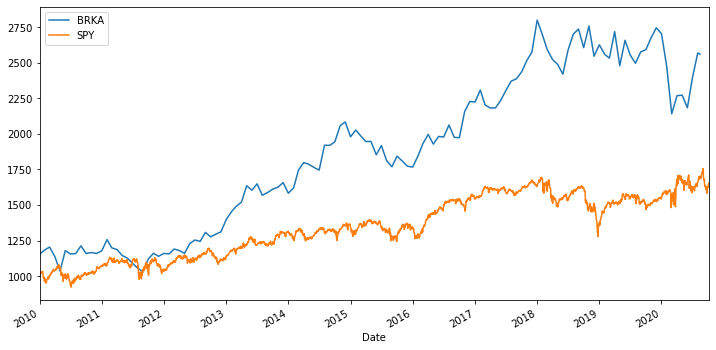

In [7]:
spy_wealth = 1000*(1+spy_data["rets"]).cumprod()
brka_wealth = 1000*(1+brka_recent["rets"]).cumprod()
brka_wealth.plot.line(label="BRKA", legend=True, figsize=(12,6))
spy_wealth.plot.line(label="SPY", legend=True)

In [8]:
import utils as utils
rfr = 1.02**(1/252)-1 # PyPortfolioOpt default rate for consistency
brk_rets = utils.annualize_rets(brka_recent["rets"], 12)
brk_vol = utils.annualize_vol(brka_recent["rets"], 12)
brk_sharpe = utils.sharpe_ratio(brka_recent["rets"],rfr, 12)
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088


# Efficient Frontier
I have extracted a summary of what is Efficient Frontier from investopedia's website https://www.investopedia.com/terms/e/efficientfrontier.asp

"What Is the Efficient Frontier?
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return."

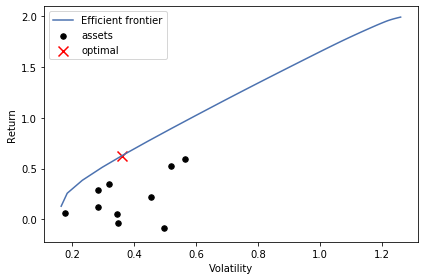

In [9]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import cla
# Read in price data

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(eq_pivot)
S = risk_models.sample_cov(eq_pivot)

# Optimise for maximal Sharpe ratio
cla = cla.CLA(mu, S, weight_bounds=(-1,1))
plotting.plot_efficient_frontier(cla, points=100, show_assets=True)

In [10]:
weights_df = pd.DataFrame(mu.index)
weights_df["Weights"] = cla.weights
weights_df

,Symbol,Weights
0,AAPL,0.548060
1,AMZN,0.328076
2,APA,-0.207242
3,AXP,0.100195
4,KO,0.141918
5,NFLX,0.230348
6,SU,-0.302962
7,TSLA,0.286998
8,UAA,0.087292
9,XRX,-0.212683


In [11]:
print("EF Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (cla.portfolio_performance()))
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

EF Portfolio Analysis:
	Expected annual return: 0.626512
	Annual Volatility: 0.360008
	Sharpe ratio: 1.684716
Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088
